In [5]:
# import libraries
import pandas as pd
from obspy import UTCDateTime, read
import pdb
import time
import os
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np

df = pd.read_csv('ISC-2004-2020.csv', header=0, parse_dates=[0])
nevent = df.shape[0]

In [10]:
# select one event for each magnitude 6, 6.5, 7, and 7.5
# and put the index numbers in a list

desired_events = [6.0, 6.5, 7.0, 7.5]
event_idx = []

for j in desired_events:
    for i in range(nevent):
        # add 0.1 +/- to the magnitude to account for rounding errors
        if df['mag'][i] - 0.1 <= j <= df['mag'][i] + 0.1:
            event_idx.append(i)
            break

print(event_idx)


[0, 16, 12, 74]


In [18]:
df['mag'][0]

6.05

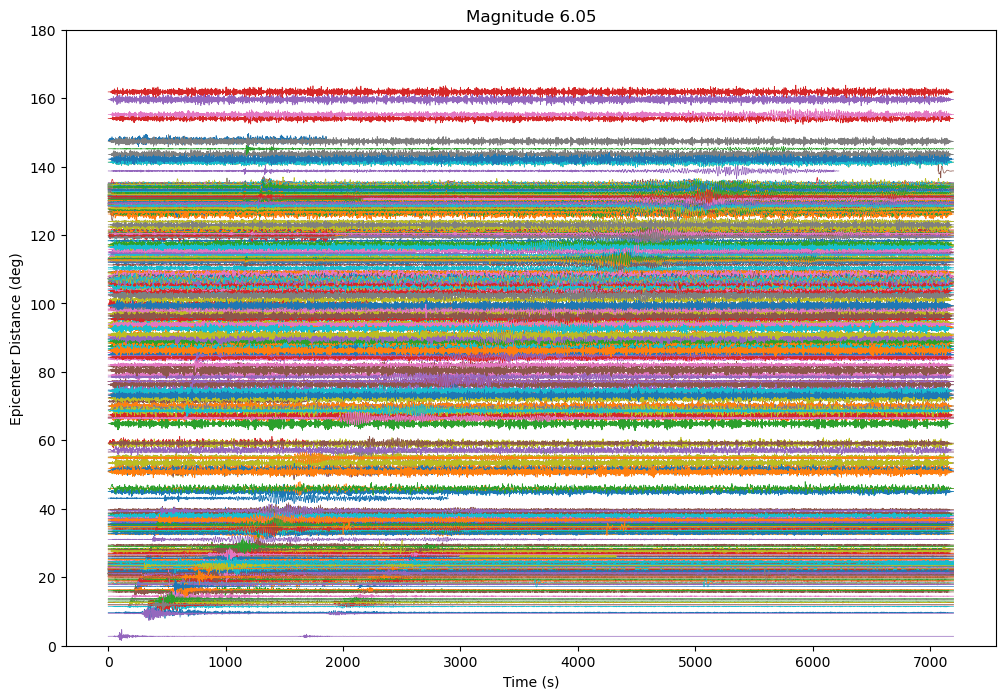

/var/folders/f8/5rwf_5jx1_798641mjmh37xss0q3js/T/ipykernel_46543/122053337.py:27: RuntimeWarning: invalid value encountered in divide
  ax.plot(t,tr.data/np.max(tr.data)*2+dist, lw=0.5)


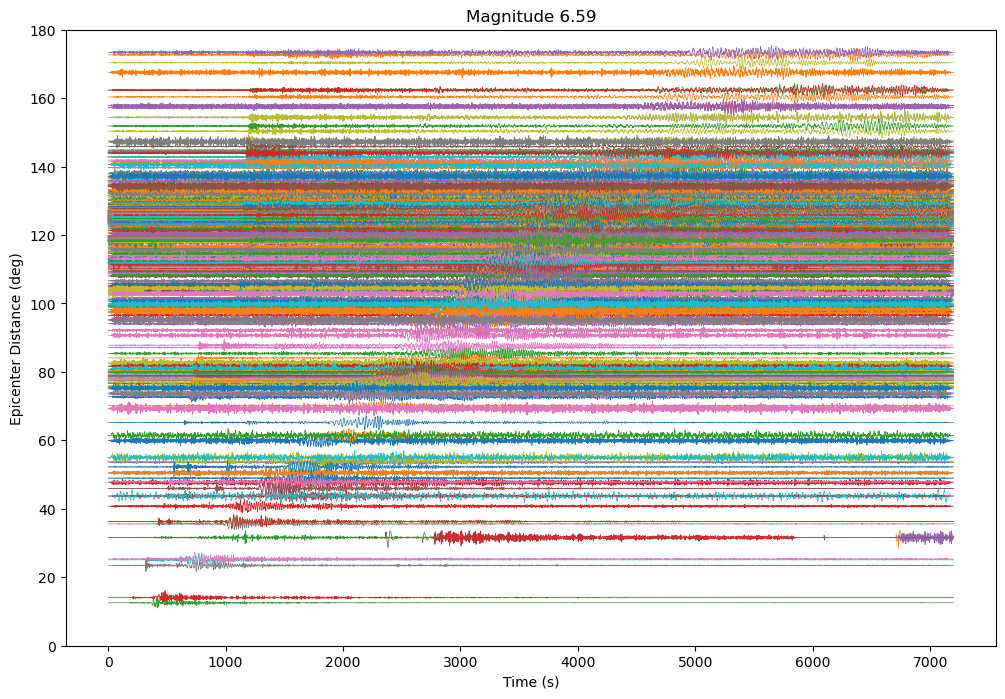

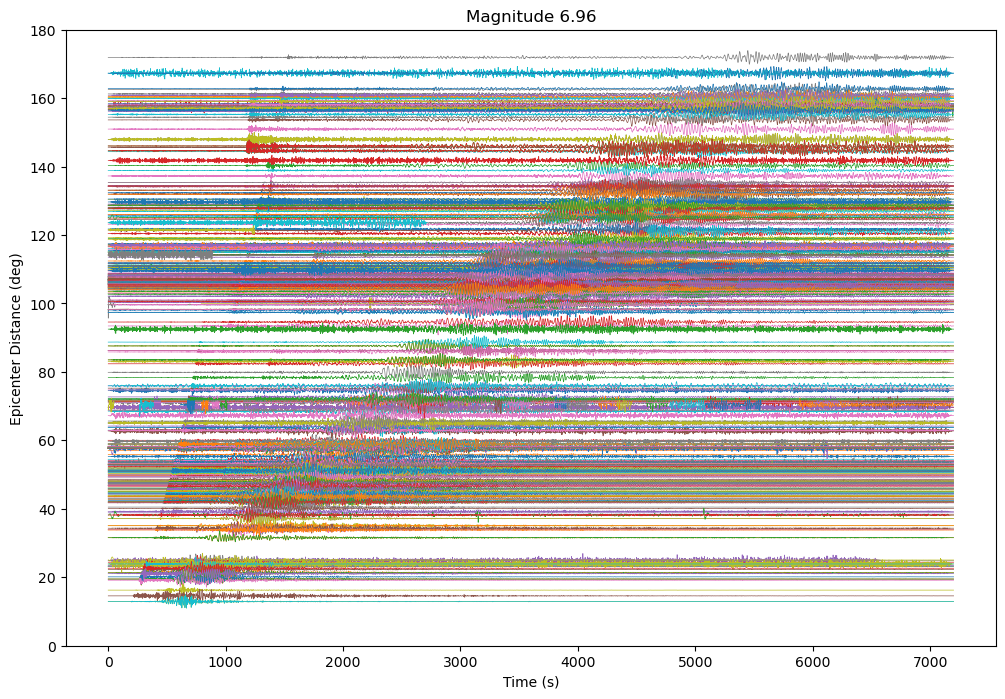

/var/folders/f8/5rwf_5jx1_798641mjmh37xss0q3js/T/ipykernel_46543/122053337.py:27: RuntimeWarning: invalid value encountered in divide
  ax.plot(t,tr.data/np.max(tr.data)*2+dist, lw=0.5)


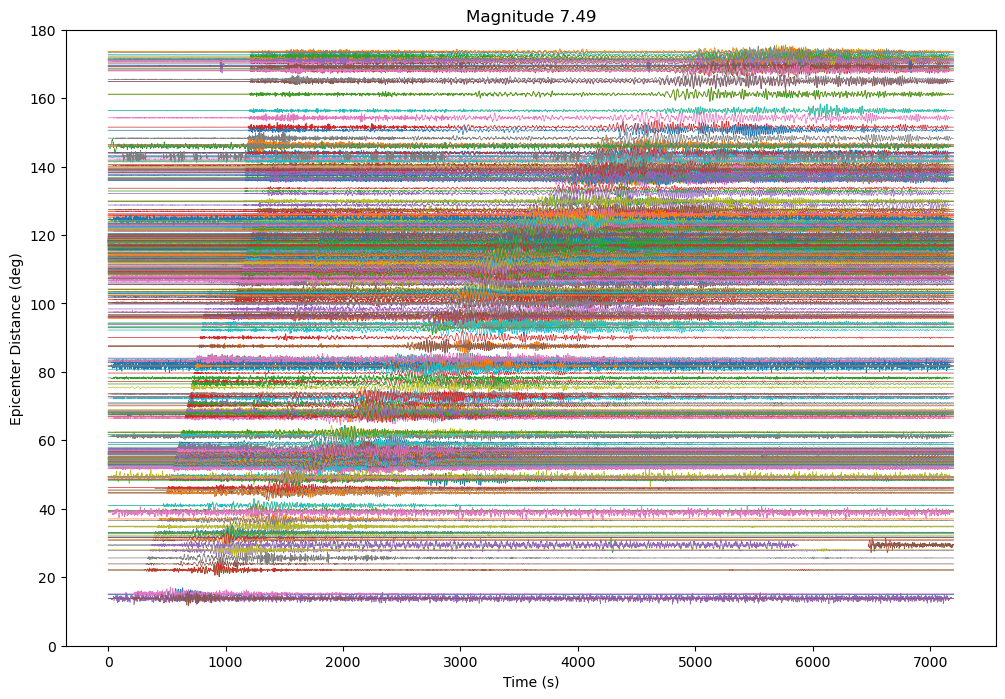

In [23]:
for i in event_idx:
    event_origin_time, elat, elon = UTCDateTime(df['date'][i]), df['lat'][i], df['lon'][i]
    st = read('Data/{}.mseed'.format(df['eventID'][i]))
    df_sta = pd.read_csv('Data/{}.txt'.format(df['eventID'][i]), header=None, sep='|', skiprows=1,\
                          usecols=[0,1,2,3,4,5],keep_default_na=False, \
                          names=['Network','Station','Location','Channel','Latitude','Longitude'],\
                          dtype={'Network':str,'Station':str,'Location':str,'Channel':str,'Latitude':float,'Longitude':float})
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    for j in range(0, len(st)):
        if not st[j].stats.channel == 'LHZ':
            continue
        # print(j)
        # # get epicenter distance
        a=df_sta.loc[(df_sta['Network']==st[j].stats.network) & (df_sta['Station']==st[j].stats.station) & \
         (df_sta['Channel']==st[j].stats.channel)]
        a=a.reset_index()
        slat, slon = a['Latitude'][0], a['Longitude'][0]
        dist = geodesic((elat, elon), (slat, slon)).km/np.pi/6371*180
        # process data
        tr = st[j]
        sampling_rate = tr.stats.sampling_rate
        t = np.arange(0, len(tr.data)) / sampling_rate + (tr.stats.starttime - event_origin_time)
        tr.detrend('demean')
        tr.filter('bandpass', freqmin=0.02, freqmax=0.4)
        tr.taper(0.01)
        ax.plot(t,tr.data/np.max(tr.data)*2+dist, lw=0.5)
    ax.set_ylim([0, 180])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Epicenter Distance (deg)')


    plt.title(f'Magnitude {df.mag[i]}')
    plt.show()
    